# The Impact of Generative AI on Children's Creative Learning Transfer

Analysis conducted by Sachin Allums

### Loading Qualtrics Data Frame

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# may need to run pip install for the given library first

In [149]:
data = pd.read_csv('honors_data_test.csv')
print(data.shape)

(73, 286)


In [150]:
def recode_likert_data(data):
    """
    Transforms all likert questions into numeric scales
    """
    mapping = {
        "Strongly agree": 5,
        "Somewhat agree": 4,
        "Neither agree nor disagree": 3,
        "Somewhat disagree": 2,
        "Strongly disagree": 1
    }
    
    return data.replace(mapping)

In [151]:
data = recode_likert_data(data)

In [152]:
def get_creative_self_efficacy(data):
    pre_efficacy_ids = ["Q24_2", "Q24_3", "Q24_4", "Q25_1", "Q25_3", "Q25_4"]
    post_efficacy_ids = ["Q42_3", "Q42_4", "Q42_5", "Q43_1", "Q43_3", "Q43_4"]

    # Convert columns to numeric (coerce non-numeric values to NaN)
    data[pre_efficacy_ids + post_efficacy_ids] = data[pre_efficacy_ids + post_efficacy_ids].apply(pd.to_numeric, errors="coerce")

    # Count valid (non-NaN) responses for each participant
    pre_valid_counts = data[pre_efficacy_ids].notna().sum(axis=1)
    post_valid_counts = data[post_efficacy_ids].notna().sum(axis=1)

    # Sum scores while ignoring NaN values
    pre_score = data[pre_efficacy_ids].sum(axis=1, skipna=True)
    post_score = data[post_efficacy_ids].sum(axis=1, skipna=True)

    # Normalize by the available number of responses
    pre_score_normalized = (pre_score - pre_valid_counts) / (4 * pre_valid_counts)
    post_score_normalized = (post_score - post_valid_counts) / (4 * post_valid_counts)

    # Compute difference
    data["pre_creative_self_efficacy"] = pre_score_normalized
    data["post_creative_self_efficacy"] = post_score_normalized
    data["difference_creative_self_efficacy"] = post_score_normalized - pre_score_normalized
    return data

In [153]:
def get_creative_personal_identity(data):
    pre_cpi_ids = ["Q234", "Q24_1", "Q25_2", "Q25_5", "Q26_1"]
    post_cpi_ids = ["Q42_1", "Q42_2", "Q43_2", "Q43_5", "Q44_1"]

    # Convert columns to numeric (coerce non-numeric values to NaN)
    data[pre_cpi_ids + post_cpi_ids] = data[pre_cpi_ids + post_cpi_ids].apply(pd.to_numeric, errors="coerce")

    # Count valid (non-NaN) responses for each participant
    pre_valid_counts = data[pre_cpi_ids].notna().sum(axis=1)
    post_valid_counts = data[post_cpi_ids].notna().sum(axis=1)

    # Sum scores while ignoring NaN values
    pre_score = data[pre_cpi_ids].sum(axis=1, skipna=True)
    post_score = data[post_cpi_ids].sum(axis=1, skipna=True)

    # Normalize by the available number of responses
    pre_score_normalized = (pre_score - pre_valid_counts) / (4 * pre_valid_counts)
    post_score_normalized = (post_score - post_valid_counts) / (4 * post_valid_counts)

    # Compute difference
    data["pre_creative_personal_identity"] = pre_score_normalized
    data["post_creative_personal_identity"] = post_score_normalized
    data["difference_creative_personal_identity"] = post_score_normalized - pre_score_normalized
    return data

In [154]:
data = get_creative_self_efficacy(data)
data = get_creative_personal_identity(data)

In [155]:
def prepend_first_AUT_to_embedded_data(df):
    """
    Prepends the Q23 string to AlternateUsesTask1 with a semicolon,
    updating the AlternateUsesTask1 column in the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'Q23' and 'AlternateUsesTask1' columns.
    
    Returns:
        pd.DataFrame: Modified DataFrame with updated 'AlternateUsesTask1' column.
    """
    df['AlternateUsesTask1'] = df['Q23'].str.strip() + '; ' + df['AlternateUsesTask1'].str.strip()    
    df['AlternateUsesTask5'] = df['Q72'].str.strip() + '; ' + df['AlternateUsesTask5'].str.strip()
    
    return df

In [156]:
data = prepend_first_AUT_to_embedded_data(data)

In [157]:
def prepend_alternate_uses(row):
    if row['AssignedCondition'] in ['Assisted-First', 'Fully Assisted']:
        row['AlternateUsesTask2'] = str(row['Q80']).strip() + '; ' + str(row['AlternateUsesTask2']).strip()
        row['AlternateUsesTask3'] = str(row['Q202']).strip() + '; ' + str(row['AlternateUsesTask3']).strip()
        row['AlternateUsesTask4'] = str(row['Q210']).strip() + '; ' + str(row['AlternateUsesTask4']).strip()
    else:
        row['AlternateUsesTask2'] = str(row['Q190']).strip() + '; ' + str(row['AlternateUsesTask2']).strip()
        row['AlternateUsesTask3'] = str(row['Q221']).strip() + '; ' + str(row['AlternateUsesTask3']).strip()
        row['AlternateUsesTask4'] = str(row['Q229']).strip() + '; ' + str(row['AlternateUsesTask4']).strip()
    return row

In [158]:
data = data.apply(prepend_alternate_uses, axis=1)

In [159]:
def assign_dat_columns(row):
    """
    Assigns DAT1 through DAT10 columns based on the AssignedCondition.
    
    Parameters:
        row (pd.Series): A row of the DataFrame.
        
    Returns:
        pd.Series: The row with new DAT columns assigned.
    """
    if row['AssignedCondition'] in ['Control', 'Assisted-First']:
        for i in range(1, 11):
            row[f'DAT{i}'] = row.get(f'Q37_{i}', None)
    elif row['AssignedCondition'] in ['Fully Assisted', 'Assisted-Second']:
        for i in range(1, 11):
            row[f'DAT{i}'] = row.get(f'Q193_{i}', None)
    return row

In [160]:
data = data.apply(assign_dat_columns, axis=1)

In [161]:
def score_digit_span(row):
    """
    Scores the digit span task based on the highest sequence correctly recalled.

    Parameters:
        row (pd.Series): A row of the DataFrame containing participant responses.

    Returns:
        int: The highest digit span score achieved by the participant.
    """
    # Define the correct sequences with their corresponding scores
    correct_sequences = {
        'Q141': '1376',
        'Q143': '95408',
        'Q145': '597832',
        'Q153': '4012683',
        'Q163': '83976574'
    }
    
    # Initialize the score
    score = 0
    
    # Iterate over the correct sequences
    for question, correct_answer in correct_sequences.items():
        # Check if the participant's response matches the correct answer
        if str(row.get(question, '')).strip() == correct_answer:
            # Update the score to the length of the correct sequence
            score = len(correct_answer)
    
    return score

In [162]:
digit_span_scores = data.apply(score_digit_span, axis=1)
data = pd.concat([data, digit_span_scores.rename('DigitSpanScore')], axis=1)

In [163]:
def calculate_fluency_scores(df):
    """
    Calculates fluency scores for AlternateUsesTask columns by counting semicolons.

    Parameters:
        df (pd.DataFrame): DataFrame containing AlternateUsesTask1 to AlternateUsesTask5 columns.

    Returns:
        pd.DataFrame: DataFrame with new fluency columns for each AlternateUsesTask column.
    """
    fluency_frames = {}  # Dictionary to hold new fluency columns

    for i in range(1, 6):
        col_name = f'AlternateUsesTask{i}'
        fluency_col_name = f'Fluency{i}'
        fluency_frames[fluency_col_name] = np.where(df[col_name].notna(), df[col_name].str.count(';') + 1, 0)

    # Create a DataFrame from the dictionary and concatenate it with the original DataFrame
    fluency_df = pd.DataFrame(fluency_frames, index=df.index)
    df = pd.concat([df, fluency_df], axis=1)

    return df

In [164]:
data = calculate_fluency_scores(data)

In [165]:
# Step 1: Define the cutoff date and time
cutoff_datetime = pd.to_datetime('2025-02-17 17:00:00')

# Step 2: Have a default for any errors
default_date = pd.Timestamp('2025-01-01')
data['StartDate'] = pd.to_datetime(data['StartDate'], errors='coerce').fillna(default_date)

# Step 3: Filter the DataFrame
data = data[data['StartDate'] >= cutoff_datetime]

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2843150537.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['StartDate'] = pd.to_datetime(data['StartDate'], errors='coerce').fillna(default_date)


## Divergent Association Test Model
Setting up the analysis model could take a while! Give it up to 25 seconds or so

In [166]:
import dat
#This code imports the model used to quickly analyze the divergent association test: this could take up to 20 seconds!

# GloVe model from https://nlp.stanford.edu/projects/glove/
model = dat.Model("glove.840B.300d.txt", "words.txt")

In [167]:
# Combine DAT columns into lists per row
dat_cols = [f'DAT{i}' for i in range(1, 11)]

# Make sure all words are strings and handle missing values
data[dat_cols] = data[dat_cols].astype(str).fillna('')

# Apply the DAT model to each row
def compute_dat_score(row):
    words = [word for word in row[dat_cols] if word]  # Filter out empty strings
    return model.dat(words)

data['DATScore'] = data.apply(compute_dat_score, axis=1)

In [168]:
# Recoding any Assisted Fully conditions to be Fully Assisted for consistency in data analysis
data['AssignedCondition'] = data['AssignedCondition'].replace("Assisted Fully", "Fully Assisted")

## Perceptions in AI Data Visualizations
Changes in one's perception of whether AI can be useful in the creative process or whether it is more creative than a child

In [169]:
# Set up styling
sns.set(style="whitegrid")

# Group by condition and compute mean
mean_scores = data.groupby("AssignedCondition")[["Q44_2", "Q44_3"]].mean().reset_index()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2782142659.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2782142659.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2782142659.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_3", ax=axes[1], palette="Greens_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2782142659.py:1

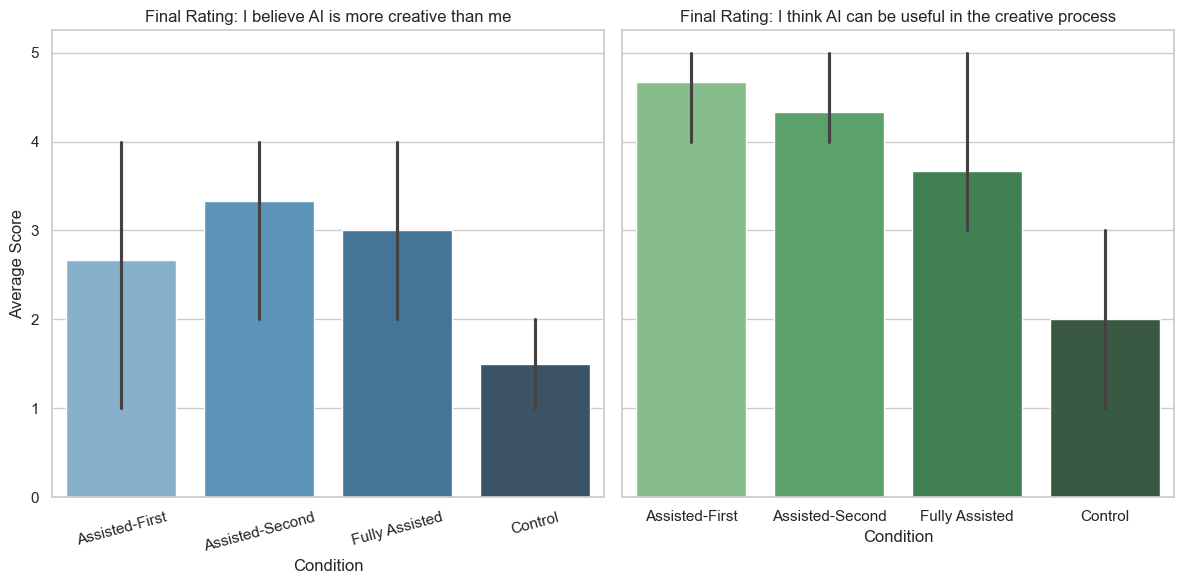

In [170]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Q44_2 Bar Chart: "I believe AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
axes[0].set_title("Final Rating: I believe AI is more creative than me")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Average Score")
axes[0].tick_params(axis='x', rotation=15)

# Q44_3 Bar Chart: "I think AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="Q44_3", ax=axes[1], palette="Greens_d", ci=95)
axes[1].set_title("Final Rating: I think AI can be useful in the creative process")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [171]:
data['Delta_Q2'] = data['Q44_2'] - data['Q26_2']
data['Delta_Q3'] = data['Q44_3'] - data['Q26_3']

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/3500027333.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/3500027333.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/3500027333.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q3", ax=axes[1], palette="Oranges_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/3

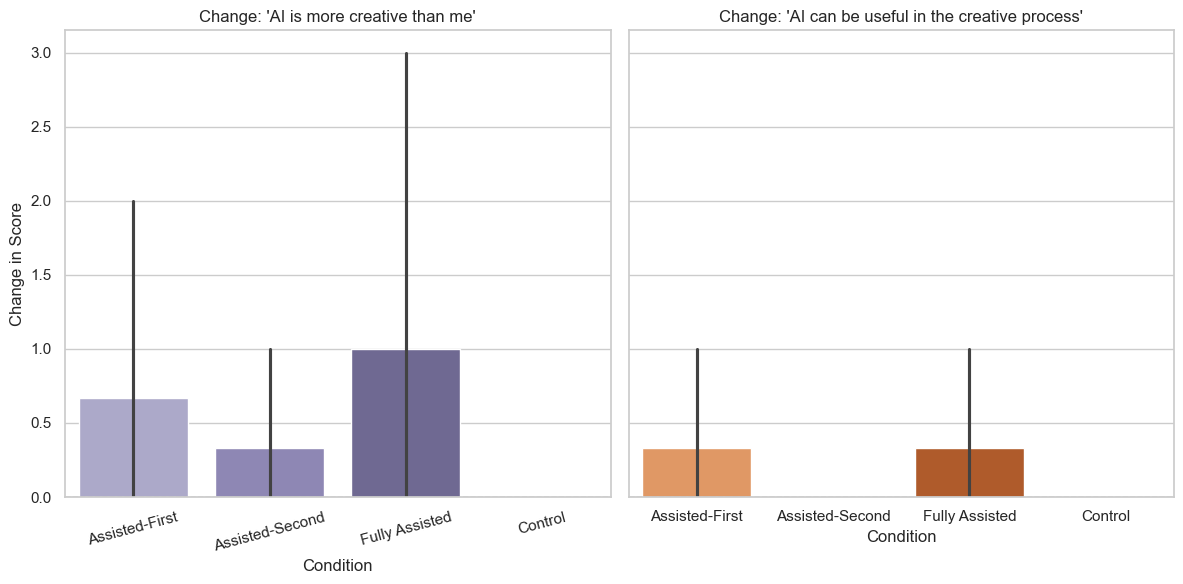

In [172]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Change in "AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
axes[0].set_title("Change: 'AI is more creative than me'")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Change in Score")
axes[0].tick_params(axis='x', rotation=15)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)

# Change in "AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="Delta_Q3", ax=axes[1], palette="Oranges_d", ci=95)
axes[1].set_title("Change: 'AI can be useful in the creative process'")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/3454001940.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/3454001940.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)


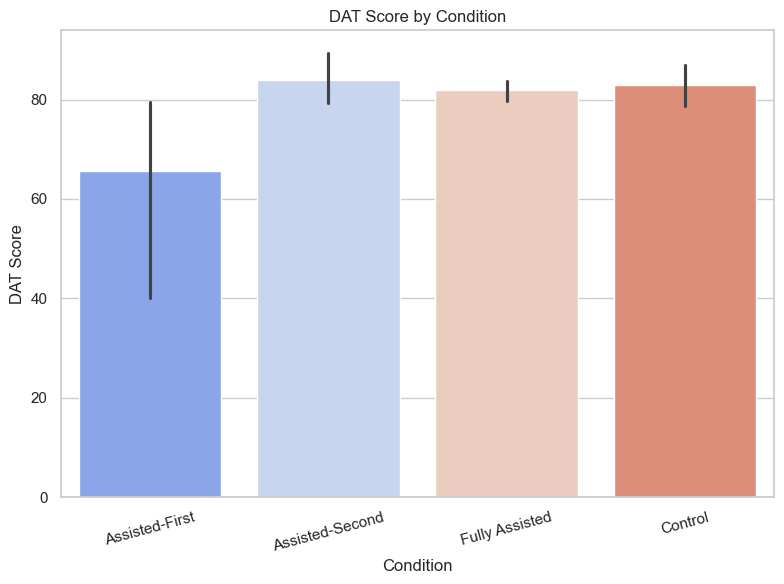

In [173]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)
plt.title("DAT Score by Condition")
plt.xlabel("Condition")
plt.ylabel("DAT Score")
plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


## Fluency Calculation and Visualization

In [ ]:
fluency_cols = ['Fluency1', 'Fluency2', 'Fluency3', 'Fluency4', 'Fluency5']
data['FluencyAverage'] = data[fluency_cols].mean(axis=1)

45    12.4
51     1.6
54     4.0
55    22.8
56     1.6
57     1.2
58     1.2
59     1.8
60     1.2
61     1.2
62     9.0
63     1.2
64    10.6
65     5.4
66     8.0
67     6.2
68     6.8
69     5.4
70     6.8
71     4.6
72     1.2
Name: FluencyAverage, dtype: float64


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/1970373375.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/1970373375.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)


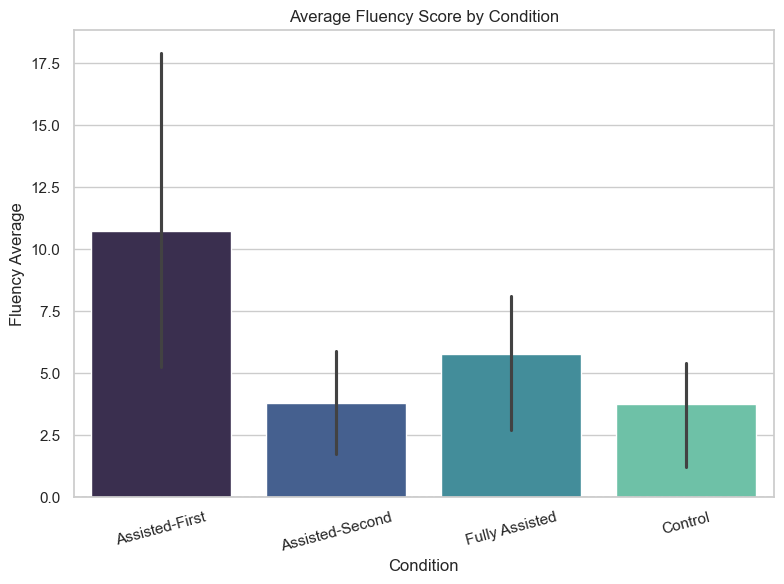

In [176]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)
plt.title("Average Fluency Score by Condition")
plt.xlabel("Condition")
plt.ylabel("Fluency Average")
plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/563401261.py:10: SyntaxWarning: invalid escape sequence '\d'
  df_long['Trial'] = df_long['Trial'].str.extract('(\d)').astype(int)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/563401261.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


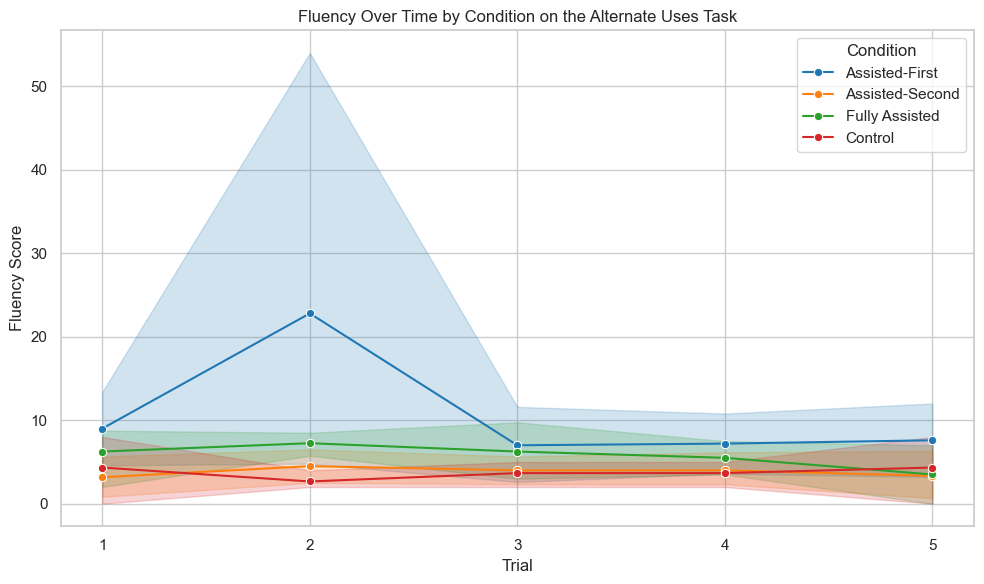

In [180]:
fluency_cols = ['Fluency1', 'Fluency2', 'Fluency3', 'Fluency4', 'Fluency5']

df_long = data.melt(
    id_vars='AssignedCondition',
    value_vars=fluency_cols,
    var_name='Trial',
    value_name='Fluency'
)

df_long['Trial'] = df_long['Trial'].str.extract('(\d)').astype(int)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_long,
    x="Trial",
    y="Fluency",
    hue="AssignedCondition",
    marker="o",
    ci=95,
    palette="tab10"
)

plt.title("Fluency Over Time by Condition on the Alternate Uses Task")
plt.xlabel("Trial")
plt.ylabel("Fluency Score")
plt.xticks(ticks=range(1, 6))
plt.legend(title="Condition")
plt.tight_layout()
plt.show()


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/3883783849.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/3883783849.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


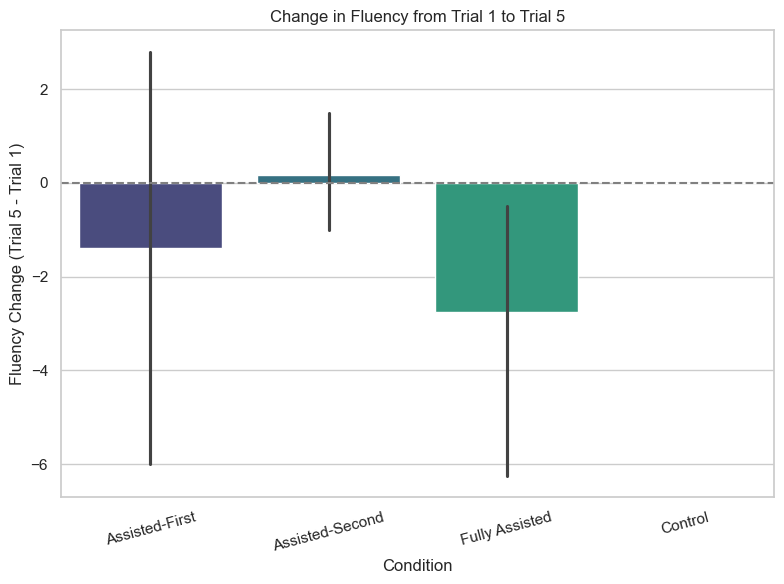

In [181]:
data['FluencyChange'] = data['Fluency5'] - data['Fluency1']

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(
    data=data,
    x="AssignedCondition",
    y="FluencyChange",
    palette="viridis",
    ci=95
)

plt.title("Change in Fluency from Trial 1 to Trial 5")
plt.xlabel("Condition")
plt.ylabel("Fluency Change (Trial 5 - Trial 1)")
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()